In [1]:
import glob, cv2, os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import json
from PIL import Image

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import albumentations as albu
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import copy
import sklearn

from tqdm import tqdm

# # retina
from utils import utils
import torchvision
from utils.engine import train_one_epoch, evaluate
float_formatter = "{:.2f}".format

In [2]:
get = 0
def draw_bounding_box(pane, rect_coordinates,category_list):
    # Show bounding boxes

    # Create figure and axes
    fig,ax = plt.subplots(1,figsize=(12, 8))
    # Display the image
    ax.imshow(pane)

    # Create a Rectangle patch
    for e , c in zip(rect_coordinates,category_list):
        (x, y, xmax, ymax) = e 
        (x, y, w, h) = (x, y, xmax-x, ymax-y)
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(x,y,category_id_to_name[c],color='blue',fontsize=9)
        
# 良性，可能良性，不確定(模玲兩可)，可能惡性，惡性，正常，本來有後來不見了，
# category_id_to_name = {1: 'Benign', 2: 'Probably benign', 3: 'Equivocal', 4: 'Probably malignant', 5: 'Malignant', 6: 'normal', 7: 'regress', 8:'Superscan'} 
category_id_to_name = {1: 'Benign', 2: 'Probably benign', 3: 'Equivocal', 4: 'Probably malignant', 5: 'Malignant', 6: 'normal', 7: 'regress', 8:'Superscan'} 

In [11]:
'''lesion data remove regress'''

final_images = glob.glob('./Step4_patch_data/images/*.png')
final_labels = glob.glob('./Step4_patch_data/labels/*.json')

final_images.sort()
final_labels.sort()
len(final_images), len(final_labels)

(1672, 1672)

./Step4_patch_data/images/BS00001_09_20190225_843a.png
(256, 512)
0
[[267, 50, 280, 56]]
[1]


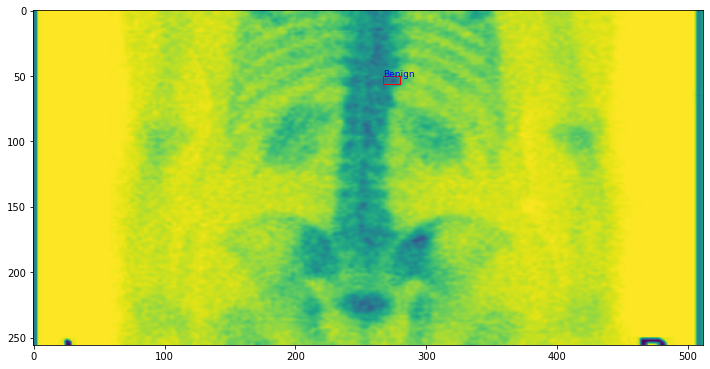

In [20]:
get = 8
img_path = final_images[get]
print(img_path)
lab_path = final_labels[get]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (1024, 1024), interpolation=cv2.INTER_AREA)
print(img.shape)
label_iter = json.load(open(lab_path))
bbox_list = []
category_list = []

for json_t in label_iter['shapes']:
    print(json_t['label'])
    category = int(json_t['label'][0])+1
    category_list.append(category)
    bbox = [int(point) for val in json_t['points'] for point in val ]
    
    # Get the left-top and right-bottom points
    if(bbox[0]>bbox[2]): 
        bbox[0],bbox[2] = swap(bbox[0],bbox[2])
    if(bbox[1]>bbox[3]): 
        bbox[1],bbox[3] = swap(bbox[1],bbox[3])
    bbox_list.append(bbox)
    
print(bbox_list)
print(category_list)
draw_bounding_box(img, bbox_list,category_list)

# Test kfold data

In [3]:
images_dir = glob.glob('./Step4_patch_data/patch_images/*')
labels_dir = glob.glob('./Step4_patch_data/patch_labels/*')
images_dir.sort()
labels_dir.sort()

len(images_dir), len(labels_dir)

(180, 180)

In [4]:
all_dir=[]
for i in range(len(images_dir)):
    package = []
    package.append(images_dir[i])
    package.append(labels_dir[i])
    all_dir.append(package)

len(all_dir), all_dir[0]

(180,
 ['./Step4_patch_data/patch_images/BS00001',
  './Step4_patch_data/patch_labels/BS00001'])

In [7]:
kfold = sklearn.model_selection.KFold(n_splits=10, shuffle=False, random_state=None)

In [8]:
kfold_train_data = [[],[],[],[],[],[],[],[],[],[]]
kfold_test_data = [[],[],[],[],[],[],[],[],[],[]]

i=0
for train_index, test_index in kfold.split(all_dir):
#     print('train_index:%s , test_index: %s ' %(train_index, test_index))
    for index in train_index:
        kfold_train_data[i].append(all_dir[index])
    for index in test_index:
        kfold_test_data[i].append(all_dir[index])
    i+=1

In [9]:
print(len(kfold_train_data[0]), len(kfold_test_data[0]))
print(len(kfold_train_data[1]), len(kfold_test_data[1]))
print(len(kfold_train_data[2]), len(kfold_test_data[2]))
print(len(kfold_train_data[3]), len(kfold_test_data[3]))
print(len(kfold_train_data[4]), len(kfold_test_data[4]))

162 18
162 18
162 18
162 18
162 18


In [10]:
kfold_train_data[0][0], kfold_train_data[1][0]

(['./Step4_patch_data/patch_images/BS00034',
  './Step4_patch_data/patch_labels/BS00034'],
 ['./Step4_patch_data/patch_images/BS00001',
  './Step4_patch_data/patch_labels/BS00001'])

In [11]:
train=[]
select = 4
for i in range(len(kfold_train_data[select])):
    img_paths = glob.glob(kfold_train_data[select][i][0]+'/*.png')
    lab_paths = glob.glob(kfold_train_data[select][i][1]+'/*.json')
    img_paths.sort()
    lab_paths.sort()
    
    for j in range(len(img_paths)):
        package=[]
        package.append(img_paths[j])
        package.append(lab_paths[j])
        train.append(package)
    
len(train), train[0], train[-1]

(1536,
 ['./Step4_patch_data/patch_images/BS00001/BS00001_00_20170103_fc78.png',
  './Step4_patch_data/patch_labels/BS00001/BS00001_00_20170103_fc78.json'],
 ['./Step4_patch_data/patch_images/BS00220/BS00220_13_20181211_665c.png',
  './Step4_patch_data/patch_labels/BS00220/BS00220_13_20181211_665c.json'])

In [12]:
test=[]
for i in range(len(kfold_test_data[select])):
    img_paths = glob.glob(kfold_test_data[select][i][0]+'/*.png')
    lab_paths = glob.glob(kfold_test_data[select][i][1]+'/*.json')
    img_paths.sort()
    lab_paths.sort()
    
    for j in range(len(img_paths)):
        package=[]
        package.append(img_paths[j])
        package.append(lab_paths[j])
        test.append(package)
    
len(test), test[0], test[-1]

(136,
 ['./Step4_patch_data/patch_images/BS00099/BS00099_13_20140730_6704.png',
  './Step4_patch_data/patch_labels/BS00099/BS00099_13_20140730_6704.json'],
 ['./Step4_patch_data/patch_images/BS00118/BS00118_13_20200730_94dc.png',
  './Step4_patch_data/patch_labels/BS00118/BS00118_13_20200730_94dc.json'])